In [1]:
from tope import Tope
from tope.net import *
from tope.orth import *
from tope.graph import Graph
from tests import normalize_polygon
from tope.plot import plot_artists_in_view

import matplotlib as mpl
import matplotlib.pyplot as plt

import json, os, numpy as np
with open("../data/polys.json") as fd: polys = json.load(fd)

In [2]:
import stl

In [3]:
v_24cell = [
    [1, 0, 0, 0], [-1, 0, 0, 0],
    [0, 1, 0, 0], [0, -1, 0, 0],
    [0, 0, 1, 0], [0, 0, -1, 0], 
    [0, 0, 0, 1], [0, 0, 0, -1],
    [1, -1, 0, 0], [-1, 1, 0, 0], 
    [1, 0, -1, 0], [-1, 0, 1, 0], 
    [1, 0, 0, -1], [-1, 0, 0, 1], 
    [0, 1, -1, 0], [0, -1, 1, 0], 
    [0, 1, 0, -1], [0, -1, 0, 1],
    [1, 0, -1, -1], [-1, 0, 1, 1], 
    [0, 1, -1, -1], [0, -1, 1, 1],
    [1, 1, -1, -1], [-1, -1, 1, 1]
]

In [4]:
v_36cell = [
    (1, 0, 0, 0),
    (0, 0, 1, 0),
    (0, -1, 0, 0),
    (0, 0, 0, -1),
    (1, 1, 0, 0),
    (-1, -1, 0, 0),
    (0, 1, 0, 0),
    (-1, 0, 0, 0),
    (0, 0, 1, 1),
    (0, 0, 0, 1),
    (0, 0, -1, -1),
    (0, 0, -1, 0)
]

In [10]:
def perspective_project(v: np.ndarray, offset: float):
    """
    Convention: project into hyperplane (v[0]=0) translated by offset.
    - v: float[M,N]
    - offset: float
    """
    return v[:,...,1:] / (v[:,...,:1] - offset)

FALLBACK_RNG = np.random.default_rng()

def random_orth(N: int, rng = FALLBACK_RNG) -> np.ndarray:
    """
    Uniform random element of O(N) with positive diagonal entries sampled using Haar measure.
    """
    Q,R = np.linalg.qr(rng.normal(size=(N,N))) # project GL(N) -> O(N)
    return Q @ np.diag(np.sign(np.diag(R)))    # fix signs

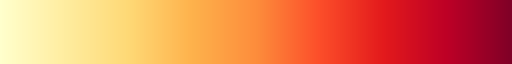

In [11]:
cmaps = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn',
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']

mpl.colormaps.get("YlOrRd")

In [42]:
def create_lc(edges, color_map = "Set2"):
    segments = []
    colors = []
    cmap = mpl.cm.get_cmap(color_map)
    for i, edge in enumerate(edges):
        segments.append(edge)
        colors.append(cmap(0.25+ 0.5*i/len(edges)))
    return mpl.collections.LineCollection(segments, color=colors)

# Actually do the stuff

In [41]:
P = Tope.from_vertices(v_24cell)
T = P.facet_graph().width_first_spanning_tree()
N = Net(P, T).unfold().in_own_span()

2023-02-24 13:45:24.911 | DEBUG    | tope.tope:from_vertices:93 - Computing from set of 24 vertices.
2023-02-24 13:45:24.918 | DEBUG    | tope.tope:from_vertices:102 - Found 24 facets.
2023-02-24 13:45:25.005 | DEBUG    | tope.tope:from_vertices:145 - Finished processing faces:
 [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}], [{0, 21}, {17, 10}, {8, 21}, {8, 17}, {21, 6}, {17, 6}, {17, 21}, {17, 5}, {17, 3}, {17, 13}, {17, 23}, {13, 23}, {3, 23}, {1, 11}, {1, 23}, {4, 21}, {21, 15}, {19, 21}, {21, 23}, {19, 23}, {15, 23}, {11, 23}, {5, 13}, {1, 9}, {1, 13}, {19, 6}, {13, 6}, {19, 13}, {13, 14}, {9, 13}, {9, 11}, {19, 4}, {11, 19}, {2, 19}, {9, 19}, {3, 5}, {1, 7}, {1, 3}, {1, 20}, {1, 5}, {8, 15}, {8, 3}, {3, 15}, {18, 3}, {3, 7}, {11, 7}, {4, 15}, {11, 15}, {16, 11}, {11, 4}, {12, 15}, {7, 15}, {20, 7}, {18, 7}, {16, 7}, {12, 7}, {9, 20}, {9, 14}, {16, 9}, {9, 2}, {16, 20}, {10, 5}, {5, 14}, {18, 

[[-0.74536  0.14907  0.59628]
 [ 0.      -0.44721  0.44721]
 [ 0.       0.       0.     ]]
[[-0.4714   0.2357   0.2357 ]
 [ 0.      -0.70711  0.70711]
 [ 0.       0.       0.     ]]
[[ 0.57735 -0.57735  0.     ]
 [ 0.      -0.8165   0.8165 ]
 [ 0.       0.      -0.     ]]
[[ 0.88192  0.12599 -1.00791]
 [ 0.      -0.65465  0.65465]
 [ 0.       0.       0.     ]]
[[ 0.66667 -0.33333 -0.33333]
 [ 0.       1.      -1.     ]
 [ 0.       0.       0.     ]]
[[-0.74536  0.14907  0.59628]
 [ 0.      -0.44721  0.44721]
 [ 0.       0.      -0.     ]]
[[ 0.8165  -0.40825 -0.40825]
 [ 0.       0.70711 -0.70711]
 [ 0.       0.      -0.     ]]
[[ 1.05409 -0.21082 -0.84327]
 [ 0.      -0.63246  0.63246]
 [ 0.       0.      -0.     ]]
[[ 0.8165  -0.40825 -0.40825]
 [ 0.       0.70711 -0.70711]
 [ 0.       0.       0.     ]]
[[-0.66667  0.33333  0.33333]
 [ 0.      -1.       1.     ]
 [ 0.       0.      -0.     ]]
[[ 0.4714  -0.2357  -0.2357 ]
 [ 0.      -0.70711  0.70711]
 [ 0.       0.       0.     ]]

In [49]:
# RERUN TO RANDOMIZE ORIENTATION
Q = random_orth(3)

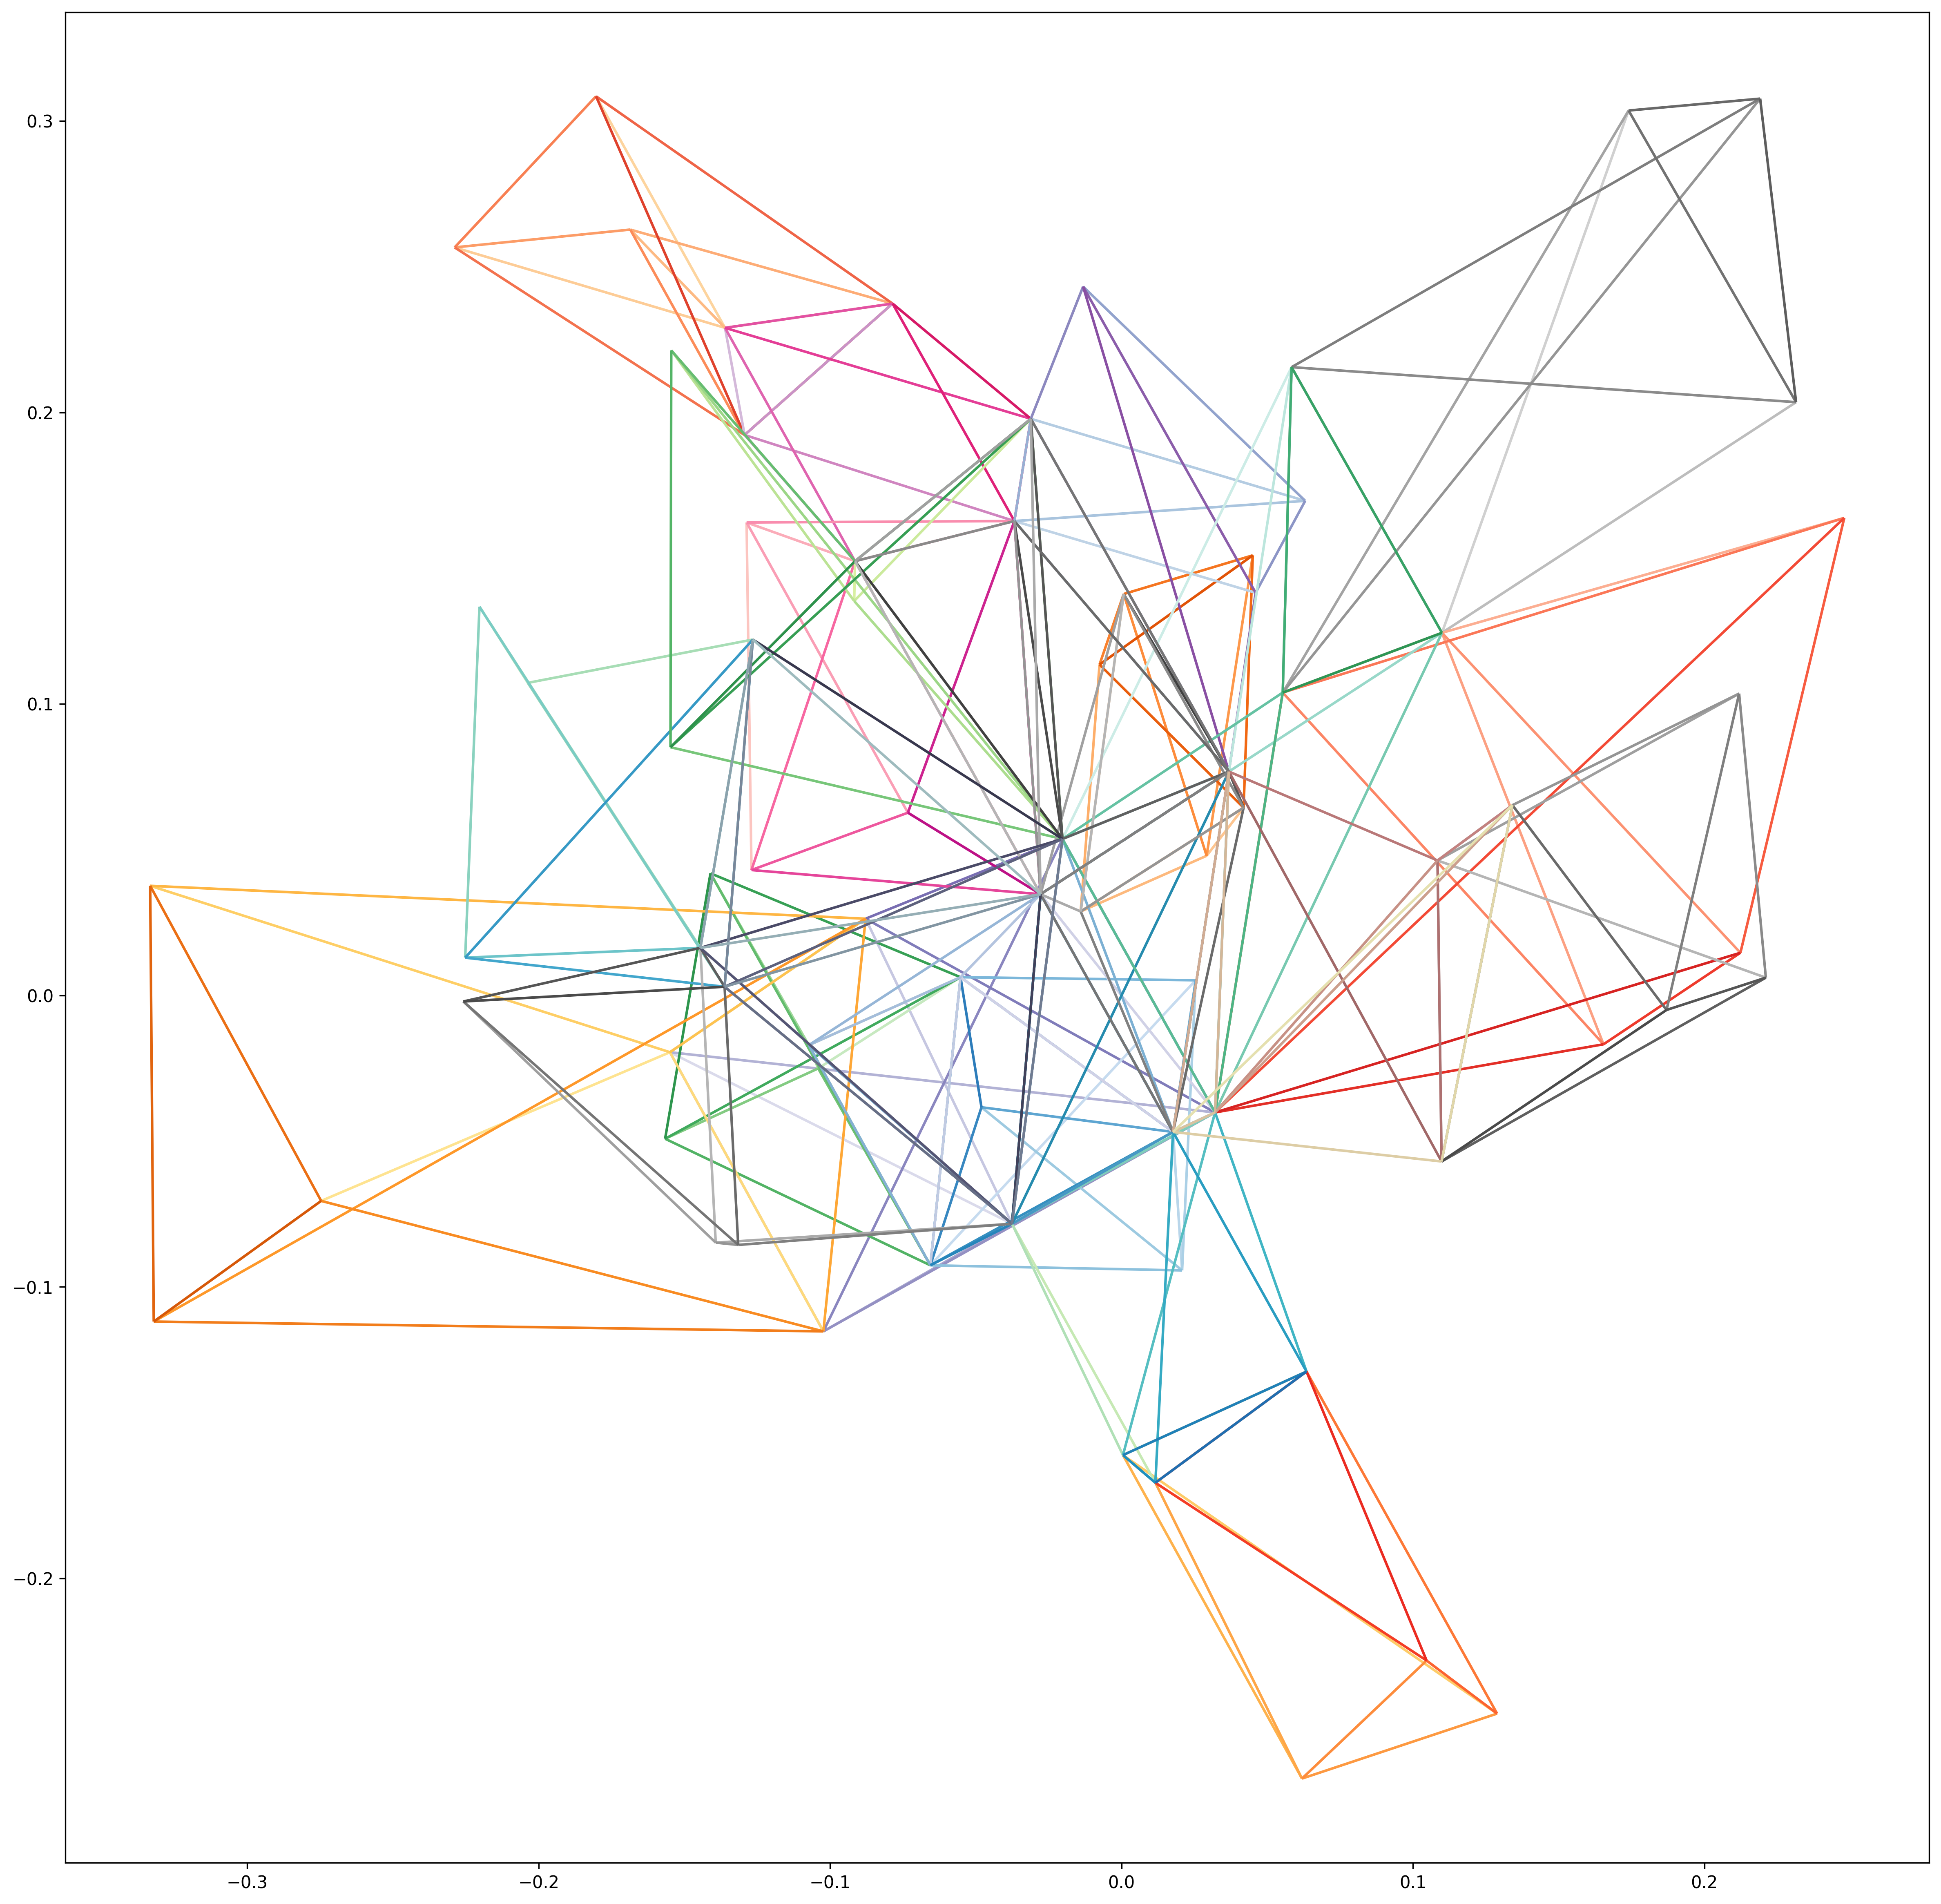

In [50]:
fig, ax = plt.subplots(dpi=300)

cell_edges = [np.stack([F.vertices[sorted(e)] for e in F.iter_faces(1)]) for F in N.facets.values()]

for n, cell in enumerate(cell_edges):
    edges = perspective_project(cell @ Q, 10)
    lc = create_lc(edges, color_map = cmaps[n%len(cmaps)])
    ax.add_collection(lc)
#    for ax in axs[:n+1]:
#        lc = create_lc(edges, color_map = cmaps[n%len(cmaps)])
#        ax.add_collection(lc)
        
#bbox = axs[0].dataLim
        
#for ax in axs:
#    ax.dataLim = bbox
ax.set_aspect("equal")
ax.autoscale()

fig.set_size_inches(20,20)
fig.savefig("nets-builder1.png")

# Make STL

In [ ]:
FILENAME = "thing24.stl"

In [51]:
faces = []
for facet in N.facets.values():
    for i in facet.faces[2]:
        D = facet.vertices[sorted(i)]
        faces.append(D)

In [52]:
thing = stl.mesh.Mesh(np.zeros(len(faces), dtype=stl.mesh.Mesh.dtype))
thing.vectors[:,:,:] = faces
thing.save(FILENAME)